# 0) Import Library

In [1]:
# Library
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import os
from datetime import datetime
import keras

# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


# 1) Function

In [0]:
# Define Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

# Tensorboard
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 2) Prepare Dataset


## 2.1) Download Data

In [3]:
# Download Data
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-04-19 15:14:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.3MB/s    in 0.8s    

2020-04-19 15:14:36 (78.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Unzip and  divide in Training and Validation
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## 2.2) Data Analysis


In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.471.jpg', 'cat.688.jpg', 'cat.844.jpg', 'cat.727.jpg', 'cat.420.jpg', 'cat.856.jpg', 'cat.869.jpg', 'cat.491.jpg', 'cat.202.jpg', 'cat.638.jpg']
['dog.736.jpg', 'dog.910.jpg', 'dog.137.jpg', 'dog.16.jpg', 'dog.506.jpg', 'dog.673.jpg', 'dog.122.jpg', 'dog.73.jpg', 'dog.220.jpg', 'dog.982.jpg']


In [7]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


## 2.3) Data Visualization

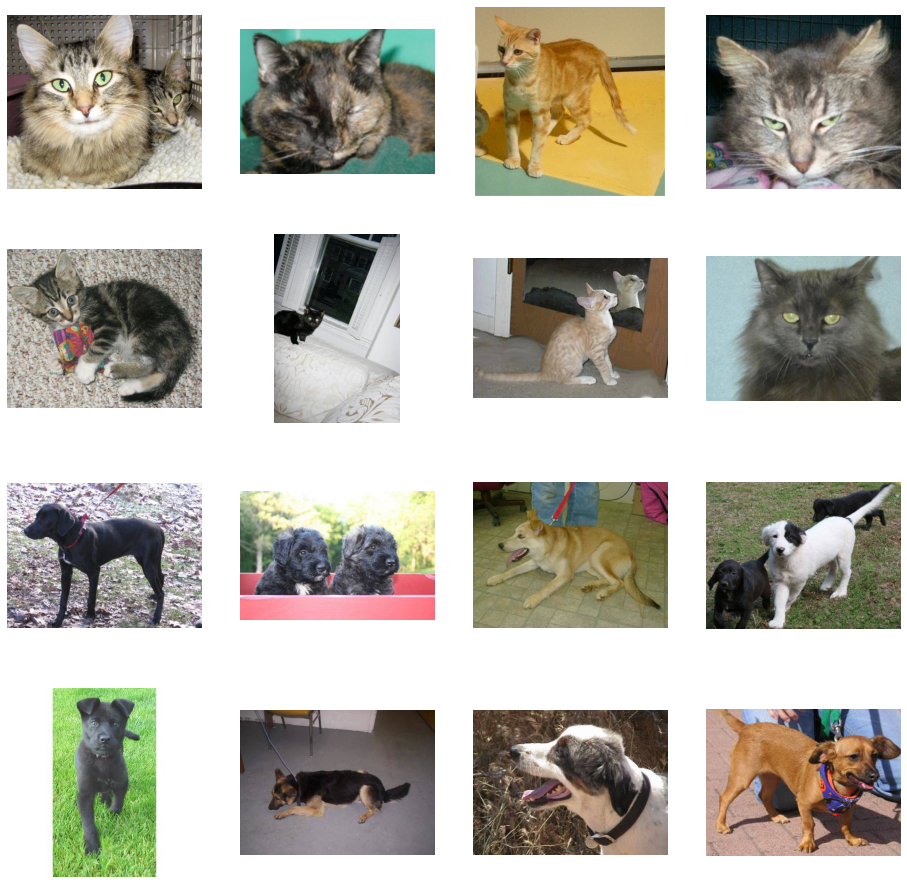

In [8]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## 2.4) Data Preprocessing


In [9]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 3) Define Model

In [0]:
# Initialize Callbacks
callbacks = myCallback()

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# 4) Training

In [0]:
# Compile Model
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [14]:
# Fitting and evaluate
history = model.fit(train_generator, steps_per_epoch=100, epochs=50, verbose=2, 
                    validation_data = validation_generator, validation_steps=50, callbacks=[tensorboard_callback])

Epoch 1/50
100/100 - 21s - loss: 0.7480 - accuracy: 0.5115 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 2/50
100/100 - 21s - loss: 0.7103 - accuracy: 0.5350 - val_loss: 0.6763 - val_accuracy: 0.5580
Epoch 3/50
100/100 - 21s - loss: 0.6899 - accuracy: 0.5730 - val_loss: 0.6427 - val_accuracy: 0.6190
Epoch 4/50
100/100 - 21s - loss: 0.6924 - accuracy: 0.6175 - val_loss: 0.6184 - val_accuracy: 0.6630
Epoch 5/50
100/100 - 21s - loss: 0.7145 - accuracy: 0.6060 - val_loss: 0.6260 - val_accuracy: 0.6450
Epoch 6/50
100/100 - 21s - loss: 0.6380 - accuracy: 0.6335 - val_loss: 0.6220 - val_accuracy: 0.6300
Epoch 7/50
100/100 - 21s - loss: 0.6401 - accuracy: 0.6395 - val_loss: 0.6015 - val_accuracy: 0.6420
Epoch 8/50
100/100 - 20s - loss: 0.6273 - accuracy: 0.6570 - val_loss: 0.5987 - val_accuracy: 0.6640
Epoch 9/50
100/100 - 20s - loss: 0.6509 - accuracy: 0.6375 - val_loss: 0.5687 - val_accuracy: 0.6950
Epoch 10/50
100/100 - 21s - loss: 0.6217 - accuracy: 0.6690 - val_loss: 0.5797 - val_accura

## TensorBoard

In [15]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

# 5) Value on Testing/Validation

In [19]:
model.evaluate(validation_generator, steps=100)

100/100 [==============================] - 7s 70ms/step - loss: 0.4091 - accuracy: 0.8280


[0.40912821888923645, 0.828000009059906]

# 6) Plot Result

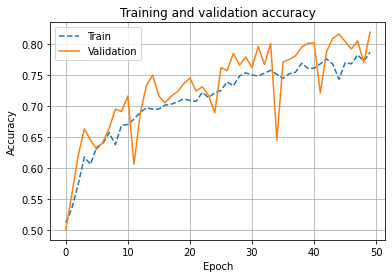

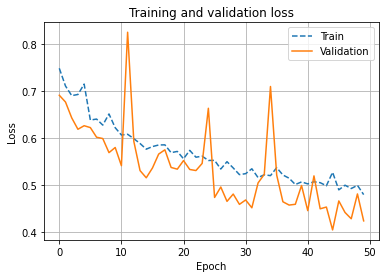

In [17]:
# Retrieve Values of accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

# Plot accuracy and loss
plt.figure(edgecolor='w', facecolor='white')
plt.grid()
plt.plot(epochs,acc, linestyle = 'dashed', label = 'Train' )
plt.plot(epochs, val_acc, label = 'Validation')
plt.title ('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation
plt.figure(edgecolor='w', facecolor='white')
plt.grid()
plt.plot( epochs,loss, linestyle = 'dashed', label = 'Train')
plt.plot( epochs, val_loss, label = 'Validation')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()